## Setup Github

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [0]:
from getpass import getpass
import os

user = "Boyne272"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

# clone the repo
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
    
# move the repo up one
!mv repo/* .
!mv repo/.git .

# delete un needed stuff
!rm -r repo
!rm -r sample_data/

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 461 (delta 4), reused 13 (delta 1), pack-reused 439
Receiving objects: 100% (461/461), 78.25 MiB | 31.53 MiB/s, done.
Resolving deltas: 100% (249/249), done.


### Github Commands

In [0]:
!git checkout richard
# !git reset --hard
!git pull origin richard
!ls -l
!git log -1

D	.gitignore
Branch 'richard' set up to track remote branch 'richard' from 'origin'.
Switched to a new branch 'richard'
From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            richard    -> FETCH_HEAD
Already up to date.
total 32
drwxr-xr-x 2 root root  4096 May 22 13:36 data
drwxr-xr-x 7 root root  4096 May 22 13:36 models
-rw-r--r-- 1 root root   771 May 22 13:36 README.md
drwxr-xr-x 2 root root  4096 May 22 13:36 spec
-rw-r--r-- 1 root root 10208 May 22 13:36 tools.py
drwxr-xr-x 3 root root  4096 May 22 13:36 training
commit e363203037fc4eed622aeb4e6df5ffabbce4e603 (HEAD -> richard, origin/richard)
Merge: 35a4983 d5caf9a
Author: Boyne272 <boynerichard@yahoo.co.uk>
Date:   Wed May 22 13:20:11 2019 +0100

    Merge branch 'uni_machine' of https://github.com/msc-acse/acse-8-miniproject-softmax into richard


## Setup Imports

Ipython imports and functions

In [0]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 491kB 25.1MB/s 
     |████████████████████████████████| 215kB 53.0MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# imports from github
from tools import *

Check runtime device

In [0]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Mount google drive if wanted

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [0]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
def symbol_inflation(t_feat, t_targ, symbols=[], frac=0.2):

    # find every index in the training set we want to duplicate
    dup_indexs = []    
    for s in symbols:
        
        # find where the sybols are
        symbol_ids = np.where(t_targ == s)[0]
        
        # randomly select the fracton of them
        np.random.shuffle(symbol_ids)
        N = int(symbol_ids.size * frac)
        
        # store these indices
        dup_indexs.append(symbol_ids[:N])
        
    dup_indexs = np.array(dup_indexs).flatten()
    
    # find the features and targets we want to duplicate
    dup_feat = t_feat[dup_indexs]
    dup_targ = t_targ[dup_indexs]
    
    # add to the data sets
    t_feat = np.concatenate([t_feat, dup_feat], axis=0)
    t_targ = np.concatenate([t_targ, dup_targ], axis=0)

    return t_feat, t_targ

In [0]:
def create_dataset(train, targ, t_id, v_id, symbols=[], frac=0.2):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(24),
        Pad(2),
        RandomRotation(15),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    
    if symbols != []:
        t_feat, t_targ = symbol_inflation(t_feat, t_targ, symbols, frac)
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [0]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into n_fold sets

In [0]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index, symbols=[1], frac=0.5)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape, len(data_loders[0, 0].dataset)

avg: 0.19193742228372832 std: 0.3484717402643013
avg: 0.1917338998562388 std: 0.34832169306624683


((2, 2), 56700)

Look at the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.0643)
batch std: tensor(0.9554)


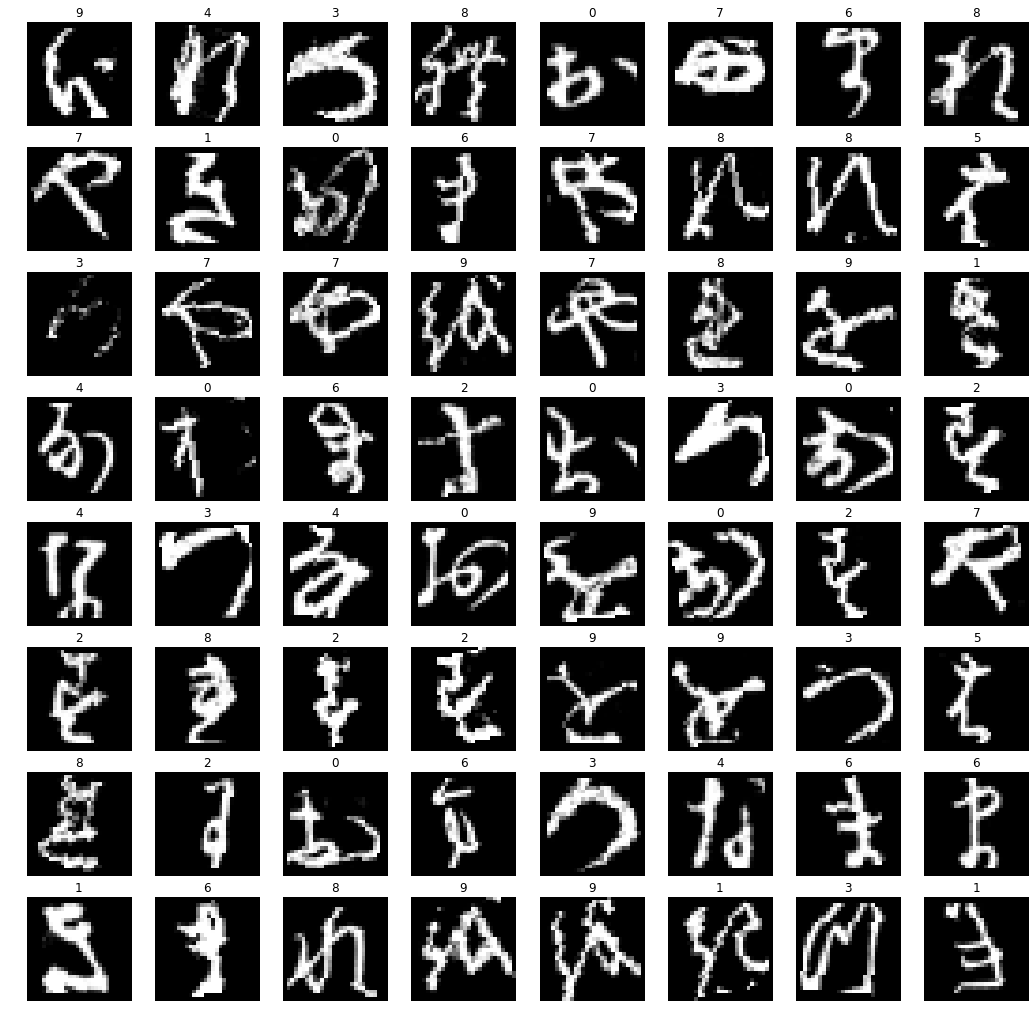

In [0]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

What about the standard deviation and mean. Here I manually do the transformation on each sample and look at the transformed data mean, std and shape.

In [0]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(-0.0005), tensor(0.9996), torch.Size([60000, 1, 28, 28]))

## Symbol Inflation


In [0]:
def symbol_inflation(t_feat, t_targ, symbols=[], frac=0.2):

    # find every index in the training set we want to duplicate
    dup_indexs = []    
    for s in symbols:
        
        # find where the sybols are
        symbol_ids = np.where(t_targ == s)[0]
        
        # randomly select the fracton of them
        np.random.shuffle(symbol_ids)
        N = int(symbol_ids.size * frac)
        
        # store these indices
        dup_indexs.append(symbol_ids[:N])
        
    dup_indexs = np.array(dup_indexs).flatten()
    
    # find the features and targets we want to duplicate
    dup_feat = t_feat[dup_indexs]
    dup_targ = t_targ[dup_indexs]
    
    # add to the data sets
    t_feat = np.concatenate([t_feat, dup_feat], axis=0)
    t_targ = np.concatenate([t_targ, dup_targ], axis=0)

    return t_feat, t_targ

In [0]:
# test this
t_index, v_index = indices[0]
t_feat, t_targ = train_feat[t_index], train_targ[t_index]

print("pre-inflation:", t_feat.shape, t_targ.shape)
print(np.unique(t_targ, return_counts=True)[1])

t_feat, t_targ = symbol_inflation(t_feat, t_targ, [0, 1], frac=1)
print("post-inflation:", t_feat.shape, t_targ.shape)
print(np.unique(t_targ, return_counts=True)[1])

pre-inflation: (54000, 28, 28) (54000,)
[5400 5400 5400 5400 5400 5400 5400 5400 5400 5400]
post-inflation: (64800, 28, 28) (64800,)
[10800 10800  5400  5400  5400  5400  5400  5400  5400  5400]
